# Green Investment Portfolio Optimization with Genetic Algorithms

## Introduction

Sustainable investing, also known as Environmental, Social and Governance (ESG) investing, is becoming increasingly popular. Investors are now looking beyond just financial returns and considering the impact of their investments on the environment and society. ESG investing focuses on building portfolios that not only perform well financially but also contribute positively to environmental, social and governance issues.

Traditional portfolio optimization methods primarily aim to maximize returns and minimize risks. However, incorporating ESG factors adds complexity as it requires balancing both financial and non-financial objectives.

In this project, we use genetic algorithms to optimize investment portfolios by integrating ESG factors along with traditional financial metrics. Genetic algorithms, inspired by natural selection, are powerful tools for solving complex optimization problems with multiple goals.

The main goals of this project are:

1. To create a fitness function that combines returns, risks, Sharpe ratios and ESG scores to evaluate portfolios.

2. To implement a genetic algorithm that evolves portfolios over several generations to find the best portfolio.

3. To compare different selection methods (tournament and roulette wheel) used in the genetic algorithm.

4. To optimize hyperparameters of the genetic algorithm to improve performance.

5. To visualize the results and understand the trade-offs between financial performance and ESG considerations.

By the end of this project, we will demonstrate how genetic algorithms can be used to create 'green' investment portfolios that align with sustainable and socially responsible investing principles.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
import itertools

## Data Acquisition

In this project, we will focus on S&P 500 stocks for the year 2022. The dataset will consist of both financial data and ESG (Environmental, Social and Governance) scores.

The financial data, including stock returns, prices and other relevant metrics, will be fetched from the Wharton Research Data Services (WRDS). Specifically, we will use the CRSP (Center for Research in Security Prices) database to obtain historical stock data for S&P 500 firms.

The ESG scores for the S&P 500 firms will be sourced from a dataset available on Kaggle. This dataset includes ESG ratings recorded at the end of 2022 or the beginning of 2023. You can access the dataset [here](https://www.kaggle.com/datasets/flamingmasamune/s-and-p-500-firms-esg-ratings/data).

We chose the year 2022 for our analysis because the ESG scores were last recorded at the end of 2022 or the beginning of 2023. This will ensure that our financial data and ESG scores are aligned in terms of the time period.

### Connect to WRDS Database

In [2]:
try:
    conn = wrds.Connection()
    print("Connected to WRDS successfully.")
except Exception as e:
    print(f"Failed to connect to WRDS: {str(e)}")

Loading library list...
Done
Connected to WRDS successfully.


### Load CRSP Data
The data includes stock prices, returns, ticker symbols, company names, share codes, exchange codes and SIC codes.

In [3]:
# Load CRSP data
crsp_data = conn.raw_sql("""
    select b.date, b.permno, b.ret, b.prc,
           c.ticker, c.comnam, c.shrcd, c.exchcd, c.siccd
    from crsp.msp500list as a
    join crsp.msf as b on a.permno = b.permno
    left join crsp.msenames as c on b.permno = c.permno
        and b.date >= c.namedt and b.date <= c.nameendt
    where b.date >= a.start and b.date <= a.ending
        and b.date >= '01/01/2022' and b.date <= '2022-12-31'
        and c.shrcd between 10 and 11
        and c.exchcd >= -2
    order by c.ticker, b.date;
    """, date_cols=['date'])

In [4]:
crsp_data.head()

,date,permno,ret,prc,ticker,comnam,shrcd,exchcd,siccd
0,2022-01-31,87432,-0.126026,139.32001,A,AGILENT TECHNOLOGIES INC,11,1,3825
1,2022-02-28,87432,-0.064312,130.36000,A,AGILENT TECHNOLOGIES INC,11,1,3825
2,2022-03-31,87432,0.015112,132.33000,A,AGILENT TECHNOLOGIES INC,11,1,3825
3,2022-04-29,87432,-0.097106,119.27000,A,AGILENT TECHNOLOGIES INC,11,1,3825
4,2022-05-31,87432,0.069506,127.56000,A,AGILENT TECHNOLOGIES INC,11,1,3825


### Load Fama-French Factors
The data includes market excess returns and risk-free rates for each month of 2022.

In [5]:
# Load Fama-French factors
ff_factors = conn.raw_sql("""
    select date, mktrf, rf
    from ff.factors_monthly
    where date >= '01/01/2022' and date <= '2022-12-31'
    order by date;
    """, date_cols=['date'])

In [6]:
ff_factors

,date,mktrf,rf
0,2022-01-01,-0.0625,0.0000
1,2022-02-01,-0.0229,0.0000
2,2022-03-01,0.0305,0.0001
3,2022-04-01,-0.0946,0.0001
4,2022-05-01,-0.0034,0.0003
5,2022-06-01,-0.0843,0.0006
6,2022-07-01,0.0957,0.0008
7,2022-08-01,-0.0377,0.0019
8,2022-09-01,-0.0935,0.0019
9,2022-10-01,0.0783,0.0023


### Merge CRSP and Fama-French Datasets

In [7]:
# Convert dates to datetime and create month columns
crsp_data['date'] = pd.to_datetime(crsp_data['date'])
crsp_data['month'] = crsp_data['date'].dt.to_period('M')

ff_factors['date'] = pd.to_datetime(ff_factors['date'])
ff_factors['month'] = ff_factors['date'].dt.to_period('M')

# Merge the datasets on the month column
merged_data = pd.merge(crsp_data, ff_factors, on='month', how='left')

# Drop redundant date columns
merged_data.drop(columns=['date_x', 'date_y'], inplace=True)

# Reorder columns
merged_data = merged_data[['month', 'permno', 'ticker', 'ret', 'prc', 'comnam', 'shrcd', 'exchcd', 'siccd', 'mktrf', 'rf']]

# Display the merged data
merged_data.head()

,month,permno,ticker,ret,prc,comnam,shrcd,exchcd,siccd,mktrf,rf
0,2022-01,87432,A,-0.126026,139.32001,AGILENT TECHNOLOGIES INC,11,1,3825,-0.0625,0.0000
1,2022-02,87432,A,-0.064312,130.36000,AGILENT TECHNOLOGIES INC,11,1,3825,-0.0229,0.0000
2,2022-03,87432,A,0.015112,132.33000,AGILENT TECHNOLOGIES INC,11,1,3825,0.0305,0.0001
3,2022-04,87432,A,-0.097106,119.27000,AGILENT TECHNOLOGIES INC,11,1,3825,-0.0946,0.0001
4,2022-05,87432,A,0.069506,127.56000,AGILENT TECHNOLOGIES INC,11,1,3825,-0.0034,0.0003


### Data Cleaning
First, we check if each stock in our dataset covers the entire year.

In [8]:
# Check how many observations there are for each month
merged_data['month'].value_counts()

month
2022-03    451
2022-01    450
2022-02    450
2022-04    449
2022-05    449
2022-06    447
2022-07    447
2022-08    447
2022-10    447
2022-11    447
2022-12    447
2022-09    445
Freq: M, Name: count, dtype: int64

We can already notice that the number of observations per month is not homogeneous, indicating that there are tickers with less than 12 months of data.

In [9]:
# Count the number of unique months for each ticker
monthly_counts = merged_data.groupby('ticker')['month'].nunique().reset_index()
monthly_counts.rename(columns={'month': 'month_count'}, inplace=True)

# Check if all tickers have 12 months of data
missing_months = monthly_counts[monthly_counts['month_count'] < 12]

# Display the tickers with missing data
print("Tickers with missing data:", missing_months['ticker'].tolist())

# Display the count of months for tickers with missing data
monthly_counts[monthly_counts['month_count'] < 12].head()

Tickers with missing data: ['ABMD', 'ANTM', 'BALL', 'BLL', 'CEG', 'CERN', 'CSGP', 'CTXS', 'DISCA', 'DISCK', 'ELV', 'EQT', 'FB', 'FBHS', 'FSLR', 'GEN', 'GPS', 'IPGP', 'KDP', 'META', 'MOH', 'NDSN', 'NLOK', 'ON', 'PARA', 'PBCT', 'PCG', 'PENN', 'PVH', 'STLD', 'TRGP', 'TWTR', 'UA', 'UAA', 'VIAC', 'WBD', 'XLNX']


,ticker,month_count
6,ABMD,11
33,ANTM,5
47,BALL,8
60,BLL,4
78,CEG,11


There are indeed quite a few. As an example, we examine the data for a specific ticker with missing months to understand why the data is incomplete.

In [10]:
# Example of a stock with missing months
merged_data[merged_data['ticker'] == 'ANTM']

,month,permno,ticker,ret,prc,comnam,shrcd,exchcd,siccd,mktrf,rf
395,2022-01,89179,ANTM,-0.048647,440.98999,ANTHEM INC,11,1,6321,-0.0625,0.0000
396,2022-02,89179,ANTM,0.024626,451.85001,ANTHEM INC,11,1,6321,-0.0229,0.0000
397,2022-03,89179,ANTM,0.089964,491.22000,ANTHEM INC,11,1,6321,0.0305,0.0001
398,2022-04,89179,ANTM,0.021803,501.92999,ANTHEM INC,11,1,6321,-0.0946,0.0001
399,2022-05,89179,ANTM,0.015301,509.60999,ANTHEM INC,11,1,6321,-0.0034,0.0003


It is evident that the selected stock stops receiving data after a certain month.
The data for some stocks may be incomplete due to delisting from the S&P 500 index or late listing during 2022. Stocks with missing months will be removed from the analysis to ensure accurate annualized return and risk calculations.

In [11]:
# Remove stocks with missing months
merged_data = merged_data[~merged_data['ticker'].isin(missing_months['ticker'])]

### Calculate Annual Metrics
Next, we will calculate the main metrics for evaluating the performance of each portfolio.

- Annual Geometric Return, which accounts for the compounding effect of returns over the year.
$$R_{annual} = \left( \prod_{i=1}^{12} (1 + r_i) \right)^{\frac{1}{12}} - 1$$

- Annual Risk, the standard deviation of monthly returns (annualized by multiplying the square root of 12).
$$\sigma_{annual} = \sigma_{monthly} \times \sqrt{12}$$

- Annual Risk-Free Rate, the return on a risk-free investment over the year.
$$RF_{annual} = \left( \prod_{i=1}^{12} (1 + rf_i) \right)^{\frac{1}{12}} - 1$$

- Sharpe Ratio, the risk-adjusted return of an investment.
$$SR = \frac{R_{annual} - RF_{annual}}{\sigma_{annual}}$$


In [12]:
# Calculate annual geometric return
merged_data['monthly_return'] = 1 + merged_data['ret']
annual_return = merged_data.groupby('ticker')['monthly_return'].prod().reset_index()
annual_return['annual_return'] = annual_return['monthly_return'] ** (1/12) - 1
annual_return.drop(columns=['monthly_return'], inplace=True)

# Calculate annual risk
annual_risk = merged_data.groupby('ticker')['ret'].std().reset_index()
annual_risk.rename(columns={'ret': 'annual_risk'}, inplace=True)
annual_risk['annual_risk'] *= np.sqrt(12)

# Calculate the annual average risk-free rate
merged_data['monthly_rf_factor'] = 1 + merged_data['rf']
compounded_rf = merged_data['monthly_rf_factor'].prod()
annual_rf = compounded_rf ** (1/12) - 1

# Merge annual return and risk data
annual_data = pd.merge(annual_return, annual_risk, on='ticker')

# Calculate the Sharpe ratio
annual_data['sharpe_ratio'] = (annual_data['annual_return'] - annual_rf) / annual_data['annual_risk']

# Display the final annual data
annual_data.head(10)

,ticker,annual_return,annual_risk,sharpe_ratio
0,A,-0.004725,0.323814,-2.060121
1,AAL,-0.028338,0.411440,-1.678759
2,AAP,-0.037123,0.386137,-1.811517
3,AAPL,-0.025217,0.329183,-2.088767
4,ABBV,0.018173,0.227626,-2.830068
5,ABC,0.019596,0.245102,-2.622475
6,ABT,-0.019105,0.184771,-3.688210
7,ADBE,-0.042550,0.421618,-1.671941
8,ADI,-0.004180,0.379608,-1.755894
9,ADM,0.028365,0.341168,-1.858340


### Load ESG Scores
The data includes Environmental, Social and Governance ratings for S&P 500 firms, as well as an overall ESG Score for each stock.

In [13]:
# Load ESG scores
esg_df = pd.read_csv('sp500_esg.csv')
esg_df.head()

,Ticker,ESG Score,Governance Score,Environment Score,Social Score,ESG Score Date,ESG Status,CEO Full Name,CEO Gender,CEO Status,Year
0,MMM,33.61,7.72,12.33,13.56,01/08/2022,success,Mr. Michael F. Roman,male,success,22
1,AOS,25.43,6.27,7.29,11.87,01/01/2023,success,Mr. Kevin J. Wheeler,male,success,23
2,ABT,24.98,8.36,3.03,13.59,01/08/2022,success,Mr. Robert B. Ford,male,success,22
3,ABBV,27.84,9.95,1.12,16.77,01/08/2022,success,Mr. Richard A. Gonzalez,male,success,22
4,ACN,9.71,4.83,0.29,4.58,01/08/2022,success,Ms. Julie T. Spellman Sweet,female,success,22


In [14]:
# Remove unnecessary columns
esg_df = esg_df[['Ticker', 'ESG Score', 'Governance Score', 'Environment Score', 'Social Score']]

### Merge ESG Scores and Financial Data

In [15]:
# Rename 'ticker' column for consistency
esg_df.rename(columns={'Ticker': 'ticker'}, inplace=True)

# Merge datasets on the 'ticker' column
final_data = pd.merge(annual_data, esg_df, on='ticker', how='inner')

# Display the final dataset
final_data.head(10)

,ticker,annual_return,annual_risk,sharpe_ratio,ESG Score,Governance Score,Environment Score,Social Score
0,A,-0.004725,0.323814,-2.060121,15.24,6.26,0.34,8.65
1,AAL,-0.028338,0.411440,-1.678759,29.10,5.26,11.53,12.31
2,AAPL,-0.025217,0.329183,-2.088767,16.68,9.18,0.65,6.86
3,ABBV,0.018173,0.227626,-2.830068,27.84,9.95,1.12,16.77
4,ABT,-0.019105,0.184771,-3.688210,24.98,8.36,3.03,13.59
5,ADBE,-0.042550,0.421618,-1.671941,12.46,4.64,1.89,5.93
6,ADI,-0.004180,0.379608,-1.755894,23.78,5.90,10.13,7.74
7,ADM,0.028365,0.341168,-1.858340,36.40,5.01,18.23,13.16
8,ADP,-0.001041,0.320886,-2.067438,13.97,5.94,1.07,6.96
9,ADSK,-0.033478,0.441698,-1.575394,16.05,4.44,3.41,8.19


In [16]:
final_data.shape

(363, 8)

## Exploratory Data Analysis (EDA)

In [17]:
# Display basic summary statistics
final_data.describe()

,annual_return,annual_risk,sharpe_ratio,ESG Score,Governance Score,Environment Score,Social Score
count,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000
mean,-0.008891,0.327815,-2.239854,22.088347,6.815399,5.797521,9.475785
std,0.023161,0.102157,0.686736,7.006976,2.200506,5.469257,3.503775
min,-0.083836,0.119845,-5.353314,6.840000,3.080000,0.000000,1.140000
25%,-0.022202,0.259421,-2.559729,16.570000,5.280000,1.445000,7.020000
50%,-0.007414,0.315062,-2.142283,21.890000,6.320000,3.700000,9.070000
75%,0.005438,0.373662,-1.817576,26.555000,7.865000,9.340000,11.755000
max,0.067576,0.724765,-0.887987,46.020000,15.510000,24.610000,20.680000


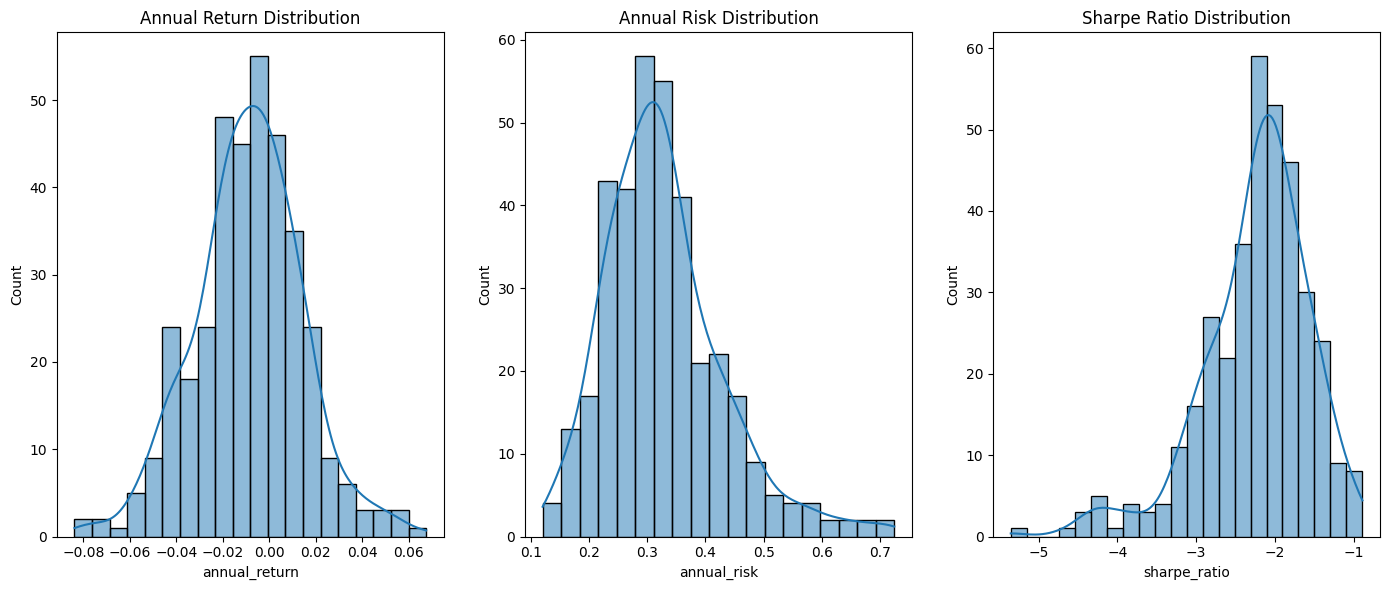

In [18]:
# Histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(final_data['annual_return'], kde=True)
plt.title('Annual Return Distribution')

plt.subplot(1, 3, 2)
sns.histplot(final_data['annual_risk'], kde=True)
plt.title('Annual Risk Distribution')

plt.subplot(1, 3, 3)
sns.histplot(final_data['sharpe_ratio'], kde=True)
plt.title('Sharpe Ratio Distribution')

plt.tight_layout()
plt.show()


- Annual Return Distribution: Approximately normal, with a slight negative skew indicating that there are more stocks with negative returns.

- Annual Risk Distribution: Right-skewed, most stocks have moderate risk, but a few have significantly higher risk.

- Sharpe Ratio Distribution: Right-skewed, most stocks have lower risk-adjusted returns, with a few outliers having very low Sharpe ratios.

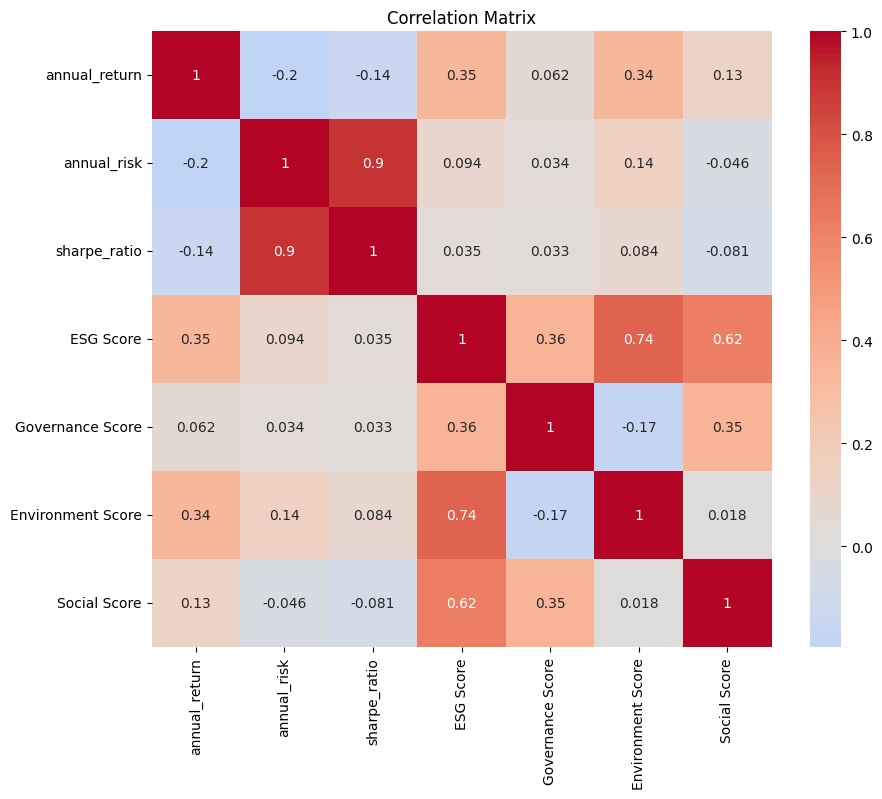

In [19]:
# Correlation matrix
correlation_matrix = final_data.drop(columns=['ticker']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

- Annual Return and ESG Score: There is a moderate positive correlation between annual returns and ESG scores, suggesting that stocks with higher ESG scores tend to have better returns.

- Annual Risk and Sharpe Ratio: There is a very high positive correlation between annual risk and Sharpe ratio. This indicates that as the risk increases, the Sharpe ratio tends to decrease, which is expected since the Sharpe ratio accounts for risk-adjusted returns.

- Governance and Social Scores: The correlation matrix also shows a pretty high correlation between governance and social scores, indicating that companies scoring high in one of these two aspects tend to score high in the other as well.

- ESG Score and Subscores: Clearly, the correlations between the overall ESG score and its subscores are high.

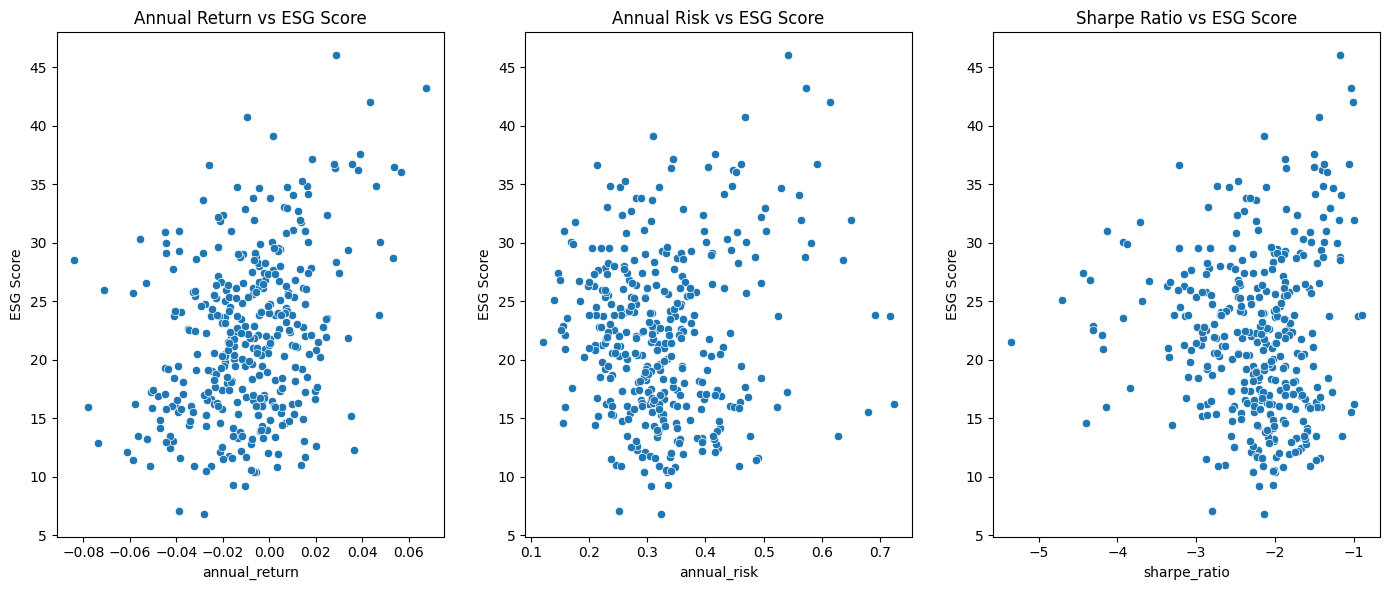

In [20]:
# Scatter plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(data=final_data, x='annual_return', y='ESG Score')
plt.title('Annual Return vs ESG Score')

plt.subplot(1, 3, 2)
sns.scatterplot(data=final_data, x='annual_risk', y='ESG Score')
plt.title('Annual Risk vs ESG Score')

plt.subplot(1, 3, 3)
sns.scatterplot(data=final_data, x='sharpe_ratio', y='ESG Score')
plt.title('Sharpe Ratio vs ESG Score')

plt.tight_layout()
plt.show()

The scatter plot shows a positive trend for returns and ESG scores, meaning that stocks with higher ESG scores seems to have higher annual returns. Similarly, Sharpe ratios and ESG scores have a there is a positive trend, indicating that stocks with higher ESG scores tend to have better risk-adjusted returns. As for risk, however, the scatter plot shows no clear trend, which suggests that there is no strong relationship between a stock's risk and its ESG score.

## Genetic Algorithm Implementation
We are ready to implement the genetic algorithm for portfolio optimization. The algorithm includes steps for initializing the population, evaluating fitness, selecting parents, performing crossover and mutation and finding the best portfolio.

### Fitness Function
The fitness function evaluates how good a portfolio is based on various metrics. It combines returns, risks, Sharpe ratios and ESG scores to produce a single fitness score. The goal is to maximize this fitness score.

The parameters `alpha`, `beta`, `gamma1`, `gamma2`, `gamma3` and `delta` are the weights for the different factors. They are initially set to 1.0, we will explore some variations later on. We choose the fitness function to be the weighted sum of all these factors (with a negative sign for the risk). 

In [21]:
def calculate_fitness(portfolio, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, alpha=1.0, beta=1.0, gamma1=1.0, gamma2=1.0, gamma3=1.0, delta=1.0):
    portfolio_return = np.dot(portfolio, returns)
    portfolio_risk = np.dot(portfolio, risks)
    portfolio_sharpe = np.dot(portfolio, sharpe_ratios)
    portfolio_esg = np.dot(portfolio, esg_scores)
    portfolio_env = np.dot(portfolio, env_scores)
    portfolio_soc = np.dot(portfolio, soc_scores)
    portfolio_gov = np.dot(portfolio, gov_scores)

    fitness = (alpha * portfolio_sharpe) + (beta * portfolio_esg) + (gamma1 * portfolio_env) + (gamma2 * portfolio_soc) + (gamma3 * portfolio_gov) + (delta * portfolio_return) - (delta * portfolio_risk)
    return fitness

### Normalize Function
The normalize function ensures that the portfolio weights sum to 1, a fundamental constraint in portfolio optimization.

In [22]:
def normalize(weights):
    return weights / np.sum(weights)

### Initialize Population
This function generates an initial population of random portfolios. Each portfolio is a random set of weights that sum to 1.

In [23]:
def initialize_population(pop_size, num_assets):
    population = [normalize(np.random.rand(num_assets)) for _ in range(pop_size)]
    return population

### Tournament Selection
Tournament selection is a method of selecting individuals from the population to serve as parents for the next generation. It works as follows:
1. Randomly select a subset (tournament) of `k` individuals from the population.
2. Determine the individual with the highest fitness score within this subset.
3. Repeat this process until the desired number of parents is selected.

In [24]:
def tournament_selection(population, fitness_scores, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = np.random.choice(len(population), k, replace=False)
        best = max(tournament, key=lambda i: fitness_scores[i])
        selected.append(population[best])
    return selected

### Roulette Wheel Selection
Roulette wheel selection, also known as fitness proportionate selection, selects parents based on their fitness scores relative to the total fitness of the population. It works as follows:
1. Calculate the total fitness of the population.
2. Compute the relative fitness for each individual, which is the individual's fitness divided by the total fitness.
3. Construct a cumulative probability distribution from the relative fitness scores.
4. Randomly select individuals based on this cumulative probability distribution.

In [25]:
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    relative_fitness = [f / total_fitness for f in fitness_scores]
    probabilities = np.cumsum(relative_fitness)
    
    selected = []
    for _ in range(len(population)):
        r = np.random.rand()
        for i, individual in enumerate(population):
            if r <= probabilities[i]:
                selected.append(individual)
                break
    return selected

### Crossover
Crossover is a genetic operator used to combine the genetic information of two parent portfolios to produce a new child portfolio. This simulates the process of genetic recombination and introduces new genetic combinations into the population. The crossover process works as follows:
1. Randomly select a crossover point along the length of the parents' portfolios.
2. Create a child portfolio by combining the first part of one parent up to the crossover point with the second part of the other parent from the crossover point onward.
3. Normalize the resulting child portfolio to ensure that the weights sum to 1.

In [26]:
def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    child = np.concatenate([parent1[:point], parent2[point:]])
    return normalize(np.maximum(child, 0))  # Ensure no negative weights

### Mutation
Mutation is a genetic operator used to introduce random changes to individual portfolios. This helps to maintain genetic diversity within the population and prevents the algorithm from becoming stuck in local optima. The mutation process works as follows:
1. With a certain probability (mutation rate), randomly select a weight in the portfolio and replace it with a new random value.
2. Normalize the resulting portfolio to ensure that the weights sum to 1.

In [27]:
def mutate(portfolio, mutation_rate=0.01):
    if np.random.rand() < mutation_rate:
        point = np.random.randint(len(portfolio))
        portfolio[point] = np.random.rand()
    return normalize(np.maximum(portfolio, 0))

### Genetic Algorithm
The genetic algorithm is an optimization technique inspired by the process of natural selection. It is used to find optimal or near-optimal solutions to complex problems. In this case, we use it to optimize an investment portfolio by balancing financial returns and ESG scores.

The genetic algorithm involves the following steps:
1. Initialization: Generate an initial population of random portfolios.
2. Evaluation: Calculate the fitness of each portfolio in the population.
3. Selection: Select parent portfolios based on their fitness.
4. Crossover: Combine parent portfolios to create new child portfolios.
5. Mutation: Introduce random changes to child portfolios to maintain genetic diversity.
6. Replacement: Form a new population with the child portfolios.
7. Termination: Repeat the process for a specified number of generations or until convergence.

In [28]:
def genetic_algorithm(returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, pop_size=100, generations=100, mutation_rate=0.01, selection='tournament'):
    num_assets = len(returns)
    population = initialize_population(pop_size, num_assets)
    
    for gen in range(generations):
        fitness_scores = np.array([calculate_fitness(p, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores) for p in population])

        if selection == 'tournament':
            parents = tournament_selection(population, fitness_scores)
        elif selection == 'roulette':
            parents = roulette_wheel_selection(population, fitness_scores)
        else:
            raise ValueError("Invalid selection method. Choose 'tournament' or 'roulette'.")

        population = []

        while len(population) < pop_size:
            parent1, parent2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[parent1], parents[parent2])
            child = mutate(child, mutation_rate)
            population.append(child)
    
    best_portfolio = max(population, key=lambda p: calculate_fitness(p, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores))
    best_fitness = calculate_fitness(best_portfolio, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores)
    return best_portfolio, best_fitness

### Running the Genetic Algorithm

We run the genetic algorithm using the prepared data arrays. The algorithm is executed twice, once using tournament selection and once using roulette wheel selection, to compare the performance of these two selection methods.

In [29]:
returns = final_data['annual_return'].values
risks = final_data['annual_risk'].values
sharpe_ratios = final_data['sharpe_ratio'].values
esg_scores = final_data['ESG Score'].values
env_scores = final_data['Environment Score'].values
soc_scores = final_data['Social Score'].values
gov_scores = final_data['Governance Score'].values

In [30]:
# Run the genetic algorithm with tournament selection
best_portfolio_tournament, best_fitness_tournament = genetic_algorithm(returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, selection='tournament')

print("Best Fitness with Tournament Selection:", best_fitness_tournament)
print("Best Portfolio with Tournament Selection:", best_portfolio_tournament)

Best Fitness with Tournament Selection: 65.76926329453092
Best Portfolio with Tournament Selection: [4.72967404e-04 3.94338632e-04 1.12801780e-04 2.66966145e-05
 3.71023415e-04 3.35447861e-04 4.29918064e-04 5.73508674e-04
 5.87765335e-05 1.84917436e-04 2.18309615e-02 7.78211248e-04
 6.81360036e-04 8.87211501e-04 6.41939270e-04 1.91832632e-04
 2.52198121e-04 2.15959558e-04 2.42428712e-04 1.09424019e-04
 5.26134670e-05 1.17888613e-05 1.78588953e-04 2.48435138e-05
 1.00112363e-04 2.45480248e-04 7.81544504e-05 9.54473209e-06
 5.87766613e-05 2.44333858e-04 4.39873485e-05 2.14844460e-04
 7.31658679e-05 1.43265336e-04 1.48283827e-05 5.97616646e-05
 1.52132326e-01 3.34350082e-04 3.83337657e-04 3.73915836e-04
 2.74443405e-04 2.81598654e-04 8.04248595e-05 2.15566628e-04
 3.40092314e-05 5.27552596e-05 1.23061535e-04 1.72933557e-04
 7.46903879e-05 1.65137448e-04 1.94086479e-04 1.18843578e-04
 1.02181986e-04 1.69295992e-04 2.40715063e-02 1.41713052e-04
 2.13446459e-05 1.41032429e-04 1.08831793e-04 

In [31]:
# Run the genetic algorithm with roulette wheel selection
best_portfolio_roulette, best_fitness_roulette = genetic_algorithm(returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, selection='roulette')

print("Best Fitness with Roulette Wheel Selection:", best_fitness_roulette)
print("Best Portfolio with Roulette Wheel Selection:", best_portfolio_roulette)

Best Fitness with Roulette Wheel Selection: 45.559949041651194
Best Portfolio with Roulette Wheel Selection: [2.21376686e-03 3.75639478e-03 7.39353538e-03 5.72541329e-03
 3.23718972e-03 3.96135645e-03 4.41217893e-03 9.34866120e-03
 4.51715453e-03 2.52800743e-03 7.47810055e-03 6.66542383e-03
 7.99936354e-03 1.49977444e-03 2.09853325e-03 3.44462394e-03
 6.26886010e-03 3.71884677e-03 2.63455456e-03 2.53864204e-04
 2.16354904e-03 3.23166010e-03 2.77468009e-03 3.63162407e-03
 5.03137752e-03 1.12882967e-04 4.71782176e-03 1.69981099e-03
 3.34594633e-03 3.09583317e-03 3.97485282e-03 1.17574057e-03
 3.74292010e-03 4.59904398e-03 5.91131702e-04 3.42135733e-03
 4.83843162e-03 5.66154303e-04 6.41751272e-04 4.57182773e-03
 5.37596203e-04 1.42633523e-03 2.60726131e-03 1.17132558e-03
 2.10233430e-03 1.41187252e-03 1.94001241e-03 2.32210794e-03
 3.25395928e-04 1.07987643e-03 3.20107831e-03 4.60491892e-03
 2.29039563e-03 1.35187432e-03 2.75964339e-03 1.82180282e-03
 3.52042838e-03 4.13287124e-03 2.8542

In [32]:
# Create a DataFrame to display the portfolio
def make_portfolio_df(portfolio):
    portfolio_df = pd.DataFrame({
        'Ticker': final_data['ticker'],
        'Weight': portfolio
    })
    
    # Sort the portfolio by weights in descending order
    portfolio_df = portfolio_df.sort_values(by='Weight', ascending=False).reset_index(drop=True)
    return portfolio_df

In [33]:
# Display the portfolio with tournament selection
portfolio_df_tournament = make_portfolio_df(best_portfolio_tournament)
print("Best Portfolio with Tournament Selection:")
print(portfolio_df_tournament.head(10))

# Display the portfolio with roulette wheel selection
portfolio_df_roulette = make_portfolio_df(best_portfolio_roulette)
print("\nBest Portfolio with Roulette Wheel Selection:")
print(portfolio_df_roulette.head(10))

Best Portfolio with Tournament Selection:
  Ticker    Weight
0    MOS  0.425539
1     GE  0.160519
2     BA  0.152132
3    FMC  0.114830
4    CAG  0.024072
5    AEE  0.021831
6    NUE  0.013393
7    VFC  0.001565
8    VLO  0.001547
9     GM  0.001308

Best Portfolio with Roulette Wheel Selection:
  Ticker    Weight
0    NRG  0.159030
1    ADM  0.009349
2    AES  0.007999
3    AEE  0.007478
4   AAPL  0.007394
5    AEP  0.006665
6    CVX  0.006374
7    AJG  0.006269
8    SHW  0.006158
9    SRE  0.005931


In [34]:
# Plot the portfolio weights
def plot_portfolio_weights(portfolio_df, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=portfolio_df.head(10), x='Ticker', y='Weight')
    plt.title(title)
    plt.xlabel('Ticker')
    plt.ylabel('Weight')
    plt.xticks(rotation=45)
    plt.show()

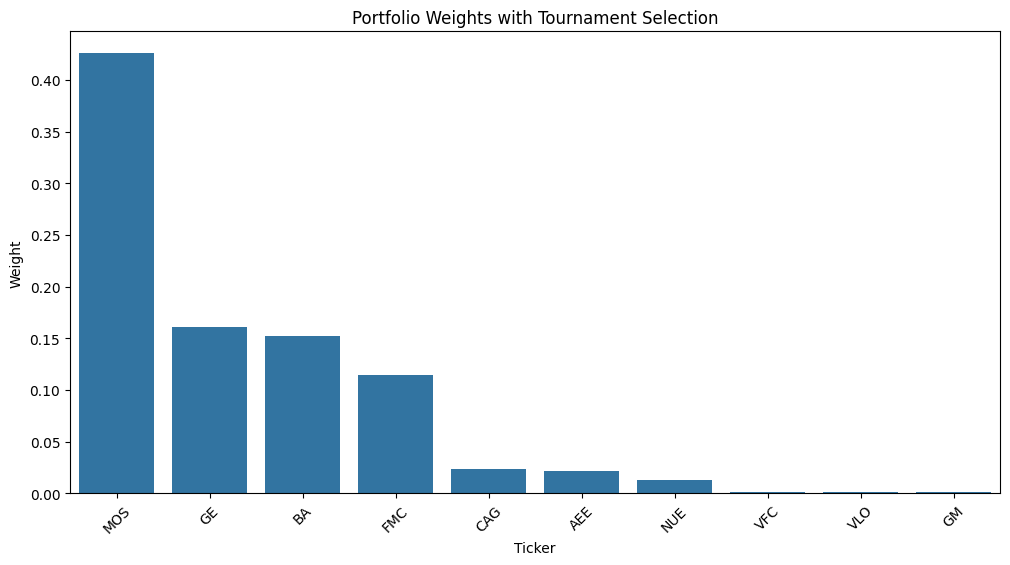

In [35]:
# Plot the portfolio weights with tournament selection
plot_portfolio_weights(portfolio_df_tournament, 'Portfolio Weights with Tournament Selection')

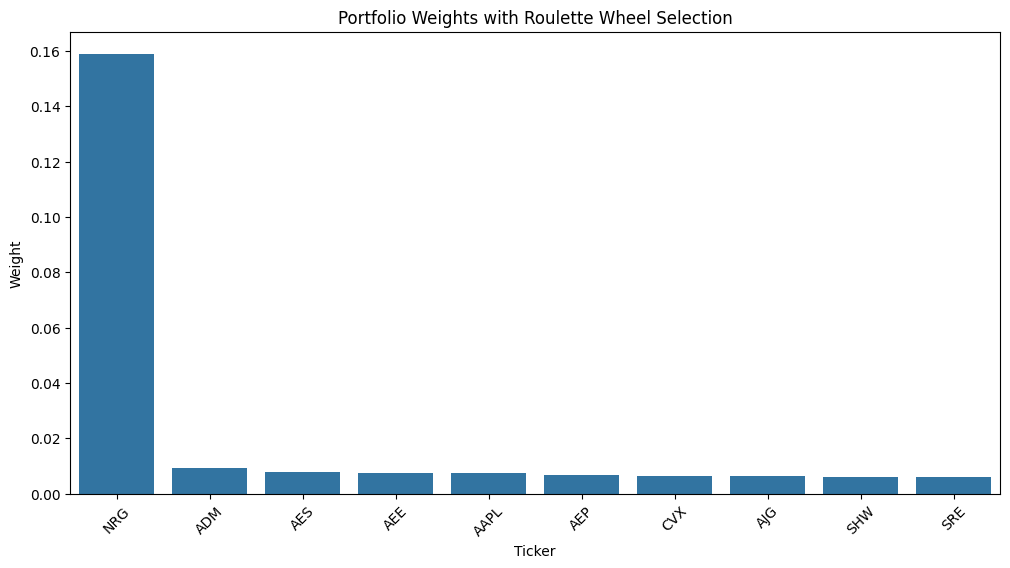

In [36]:
# Plot the portfolio weights with roulette wheel selection
plot_portfolio_weights(portfolio_df_roulette, 'Portfolio Weights with Roulette Wheel Selection')

In [37]:
# Function for calculating the portfolio return, risk and Sharpe ratio
def calculate_portfolio_performance(portfolio, returns, risks, sharpe_ratios):
    portfolio_return = np.dot(portfolio, returns)
    portfolio_risk = np.dot(portfolio, risks)
    portfolio_sharpe = np.dot(portfolio, sharpe_ratios)
    return portfolio_return, portfolio_risk, portfolio_sharpe

In [38]:
# Calculate the performance of the portfolio with tournament selection
portfolio_return_tournament, portfolio_risk_tournament, portfolio_sharpe_tournament = calculate_portfolio_performance(best_portfolio_tournament, returns, risks, sharpe_ratios)

# Calculate the performance of the portfolio with roulette wheel selection
portfolio_return_roulette, portfolio_risk_roulette, portfolio_sharpe_roulette = calculate_portfolio_performance(best_portfolio_roulette, returns, risks, sharpe_ratios)

print("Portfolio Performance with Tournament Selection:")
print(f"Return: {portfolio_return_tournament:.4f}")
print(f"Risk: {portfolio_risk_tournament:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe_tournament:.4f}")

print("\nPortfolio Performance with Roulette Wheel Selection:")
print(f"Return: {portfolio_return_roulette:.4f}")
print(f"Risk: {portfolio_risk_roulette:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe_roulette:.4f}")

Portfolio Performance with Tournament Selection:
Return: 0.0033
Risk: 0.4718
Sharpe Ratio: -1.5601

Portfolio Performance with Roulette Wheel Selection:
Return: -0.0103
Risk: 0.3525
Sharpe Ratio: -2.1108


In [39]:
# Calculate the ESG score for the portfolio
def calculate_portfolio_esg(portfolio, esg_scores, env_scores, soc_scores, gov_scores):
    portfolio_esg = np.dot(portfolio, esg_scores)
    portfolio_env = np.dot(portfolio, env_scores)
    portfolio_soc = np.dot(portfolio, soc_scores)
    portfolio_gov = np.dot(portfolio, gov_scores)
    return portfolio_esg, portfolio_env, portfolio_soc, portfolio_gov

In [40]:
# Calculate the ESG score for the portfolio with tournament selection
portfolio_esg_tournament, portfolio_env_tournament, portfolio_soc_tournament, portfolio_gov_tournament = calculate_portfolio_esg(best_portfolio_tournament, esg_scores, env_scores, soc_scores, gov_scores)
print("Portfolio ESG Score with Tournament Selection:", f"{portfolio_esg_tournament:.4f}")
print("Portfolio Environment Score with Tournament Selection:", f"{portfolio_env_tournament:.4f}")
print("Portfolio Social Score with Tournament Selection:", f"{portfolio_soc_tournament:.4f}")
print("Portfolio Governance Score with Tournament Selection:", f"{portfolio_gov_tournament:.4f}")

# Calculate the ESG score for the portfolio with roulette wheel selection
portfolio_esg_roulette, portfolio_env_roulette, portfolio_soc_roulette, portfolio_gov_roulette = calculate_portfolio_esg(best_portfolio_roulette, esg_scores, env_scores, soc_scores, gov_scores)
print("\nPortfolio ESG Score with Roulette Wheel Selection:", f"{portfolio_esg_roulette:.4f}")
print("Portfolio Environment Score with Roulette Wheel Selection:", f"{portfolio_env_roulette:.4f}")
print("Portfolio Social Score with Roulette Wheel Selection:", f"{portfolio_soc_roulette:.4f}")
print("Portfolio Governance Score with Roulette Wheel Selection:", f"{portfolio_gov_roulette:.4f}")

Portfolio ESG Score with Tournament Selection: 33.8997
Portfolio Environment Score with Tournament Selection: 12.5695
Portfolio Social Score with Tournament Selection: 12.7758
Portfolio Governance Score with Tournament Selection: 8.5528

Portfolio ESG Score with Roulette Wheel Selection: 24.0158
Portfolio Environment Score with Roulette Wheel Selection: 7.8308
Portfolio Social Score with Roulette Wheel Selection: 9.5419
Portfolio Governance Score with Roulette Wheel Selection: 6.6450


### Analysis of Results
We compare the best portfolios obtained from tournament selection and roulette wheel selection, examining their compositions, financial performance and ESG scores.

- Diversity in Portfolio Composition: The tournament selection method results in a more diversified portfolio with significant allocations across multiple stocks. The roulette wheel selection results in a concentrated portfolio, with the largest allocation to NRG and smaller allocations to a broader array of stocks.

- Financial Performance: The tournament selection method achieves a higher return and provides a slightly better Sharpe ratio compared to roulette wheel selection. This indicates a marginally better risk-adjusted performance despite having a higher risk. On the contrary, the roulette wheel selection method exhibits a lower risk but has a lower Sharpe ratio and even negative returns, indicating poorer performance.

- ESG Considerations: The portfolio from the tournament selection method has better overall ESG scores, particularly in environmental and social aspects, making it a more sustainable choice.

- Fitness Score: The tournament selection method results in a higher overall fitness score compared to the roulette wheel selection. This indicates that the tournament selection method achieves a better balance between financial performance and ESG considerations.

- Best Choice: Between the two selection methods, tournament selection provides a more balanced approach between financial performance and ESG scores, making it suitable for investors looking for sustainable and responsible investments.

## Genetic Algorithm with Hyperparameter Tuning
We now extend the genetic algorithm to include hyperparameter tuning. This consists in experimenting with different combinations of hyperparameters, to find the optimal settings that yield the best portfolio.

**Hyperparameters**:

- `pop_size`: Size of the population.
- `generations`: Number of generations to run the algorithm.
- `mutation_rate`: Probability of mutation.
- `alpha`: Weight for the Sharpe ratio in the fitness function.
- `beta`: Weight for the overall ESG score in the fitness function.
- `gamma1`: Weight for the environmental score in the fitness function.
- `gamma2`: Weight for the social score in the fitness function.
- `gamma3`: Weight for the governance score in the fitness function.
- `delta`: Weight for the return and risk in the fitness function.
- `selection`: Selection method (‘tournament’ or ‘roulette’).

In [41]:
# Genetic algorithm process with hyperparameters
def genetic_algorithm_with_params(returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, pop_size, generations, mutation_rate, alpha, beta, gamma1=1.0, gamma2=1.0, gamma3=1.0, delta=1.0, selection='tournament'):
    num_assets = len(returns)
    population = initialize_population(pop_size, num_assets)
    
    for gen in range(generations):
        fitness_scores = np.array([calculate_fitness(p, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, alpha, beta, gamma1, gamma2, gamma3, delta) for p in population])

        if selection == 'tournament':
            parents = tournament_selection(population, fitness_scores)
        elif selection == 'roulette':
            parents = roulette_wheel_selection(population, fitness_scores)
        else:
            raise ValueError("Invalid selection method. Choose 'tournament' or 'roulette'.")

        population = []
        
        while len(population) < pop_size:
            parent1, parent2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[parent1], parents[parent2])
            child = mutate(child, mutation_rate)
            population.append(child)
    
    best_portfolio = max(population, key=lambda p: calculate_fitness(p, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, alpha, beta, gamma1, gamma2, gamma3, delta))
    best_fitness = calculate_fitness(best_portfolio, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores, alpha, beta, gamma1, gamma2, gamma3, delta)
    return best_portfolio, best_fitness

### Grid Search
To find the optimal hyperparameters, we perform a grid search over a specified range of hyperparameters. It will evaluate the genetic algorithm with different combinations of hyperparameters and select the best configuration based on the fitness score.

In [42]:
# Define the hyperparameter grid
param_grid = {
    'pop_size': [50, 100, 150],
    'generations': [100, 200],
    'mutation_rate': [0.01, 0.1],
    'alpha': [0.5, 1.0],
    'beta': [0.5, 1.0]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['pop_size'],
    param_grid['generations'],
    param_grid['mutation_rate'],
    param_grid['alpha'],
    param_grid['beta']
))

In [43]:
# Function to perform grid search for a specific selection method
def perform_grid_search(selection_method):
    results = []
    best_params = None
    best_fitness = -np.inf
    best_portfolio = None

    for params in param_combinations:
        pop_size, generations, mutation_rate, alpha, beta = params
        portfolio, fitness = genetic_algorithm_with_params(
            returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores,
            pop_size, generations, mutation_rate, alpha, beta, selection=selection_method
        )

        if fitness > best_fitness:
            best_fitness = fitness
            best_portfolio = portfolio
            best_params = params
        
        results.append({
            'pop_size': pop_size,
            'generations': generations,
            'mutation_rate': mutation_rate,
            'alpha': alpha,
            'beta': beta,
            'selection': selection_method,
            'fitness': fitness
        })
    
    return pd.DataFrame(results), best_params, best_fitness, best_portfolio

In [44]:
# Perform grid search for tournament selection
results_tournament, best_params_tournament, best_fitness_tournament, best_portfolio_tournament = perform_grid_search('tournament')

print("Best Hyperparameters (Tournament):", best_params_tournament)
print("Best Fitness Score (Tournament):", best_fitness_tournament)
print("Best Portfolio (Tournament):", best_portfolio_tournament)

Best Hyperparameters (Tournament): (150, 200, 0.1, 0.5, 1.0)
Best Fitness Score (Tournament): 89.20602595531422
Best Portfolio (Tournament): [9.37607610e-06 1.49646512e-05 1.91248886e-05 6.31793697e-05
 6.38502581e-05 1.29743045e-05 6.19953553e-06 7.45357466e-05
 3.05164009e-05 6.83456814e-05 3.96746578e-05 3.93681443e-05
 5.03961830e-05 5.01342638e-05 4.11152229e-05 4.41736754e-05
 1.24637640e-05 5.70665869e-05 5.83235328e-05 1.56479250e-05
 1.10831376e-04 5.42318328e-05 8.00889880e-05 1.37808782e-04
 1.04172209e-04 9.29507273e-05 6.26743259e-05 1.60112035e-04
 3.95081756e-05 2.82905714e-05 1.78941047e-04 5.20331279e-05
 7.30948342e-05 1.84291476e-04 1.12209713e-04 8.04475133e-05
 1.20789718e-04 1.27034211e-04 4.34435046e-05 1.53005041e-05
 1.18386021e-04 5.03914562e-05 6.40868021e-05 1.20354998e-05
 1.87632472e-04 1.33585054e-04 1.83634506e-04 2.06744629e-05
 1.14400015e-04 9.52279855e-05 1.63242438e-04 1.90914840e-04
 1.75503317e-04 3.20744280e-04 5.99216216e-05 8.00038762e-05
 1.96

In [45]:
results_tournament.head(20)

,pop_size,generations,mutation_rate,alpha,beta,selection,fitness
0,50,100,0.01,0.5,0.5,tournament,51.660338
1,50,100,0.01,0.5,1.0,tournament,68.332475
2,50,100,0.01,1.0,0.5,tournament,46.948583
3,50,100,0.01,1.0,1.0,tournament,60.046758
4,50,100,0.10,0.5,0.5,tournament,58.258941
5,50,100,0.10,0.5,1.0,tournament,82.568011
6,50,100,0.10,1.0,0.5,tournament,60.607912
7,50,100,0.10,1.0,1.0,tournament,73.925279
8,50,200,0.01,0.5,0.5,tournament,52.173886
9,50,200,0.01,0.5,1.0,tournament,72.099288


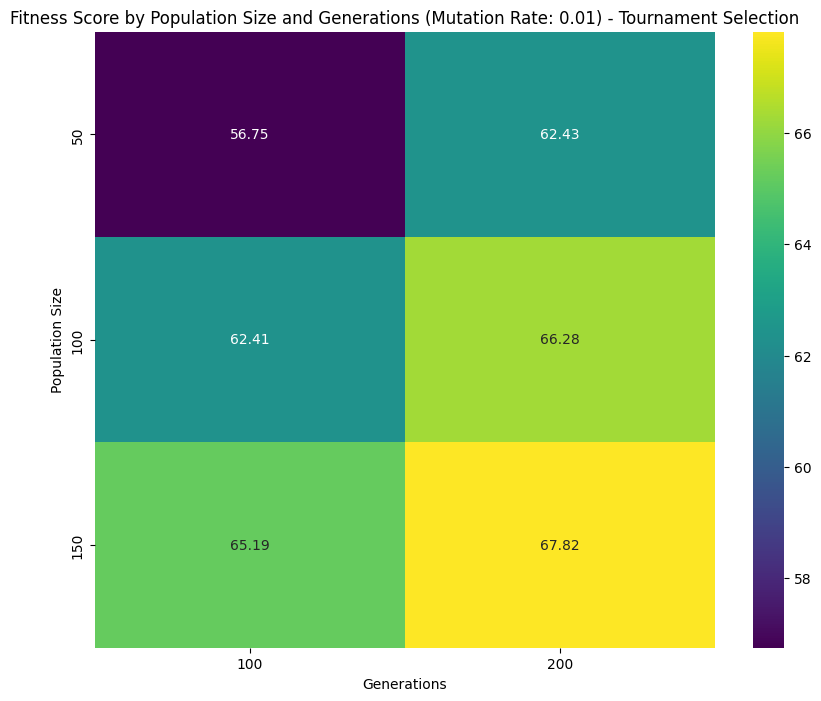

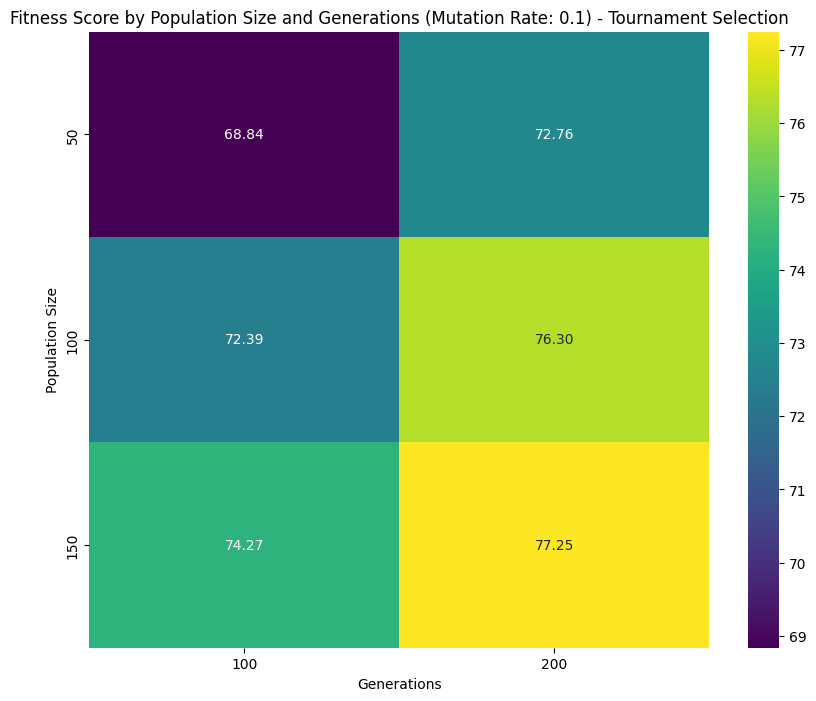

In [46]:
# Plot a heatmap of fitness scores
heatmap_data_tournament = results_tournament.groupby(['pop_size', 'generations', 'mutation_rate']).agg({'fitness': 'mean'}).reset_index()

# Get unique mutation rates
mutation_rates_tournament = heatmap_data_tournament['mutation_rate'].unique()

# Create heatmaps for each mutation rate
for mutation_rate in mutation_rates_tournament:
    subset = heatmap_data_tournament[heatmap_data_tournament['mutation_rate'] == mutation_rate]
    heatmap_data_pivot = subset.pivot(index='pop_size', columns='generations', values='fitness')

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data_pivot, annot=True, fmt=".2f", cmap='viridis')
    plt.title(f'Fitness Score by Population Size and Generations (Mutation Rate: {mutation_rate}) - Tournament Selection')
    plt.xlabel('Generations')
    plt.ylabel('Population Size')
    plt.show()

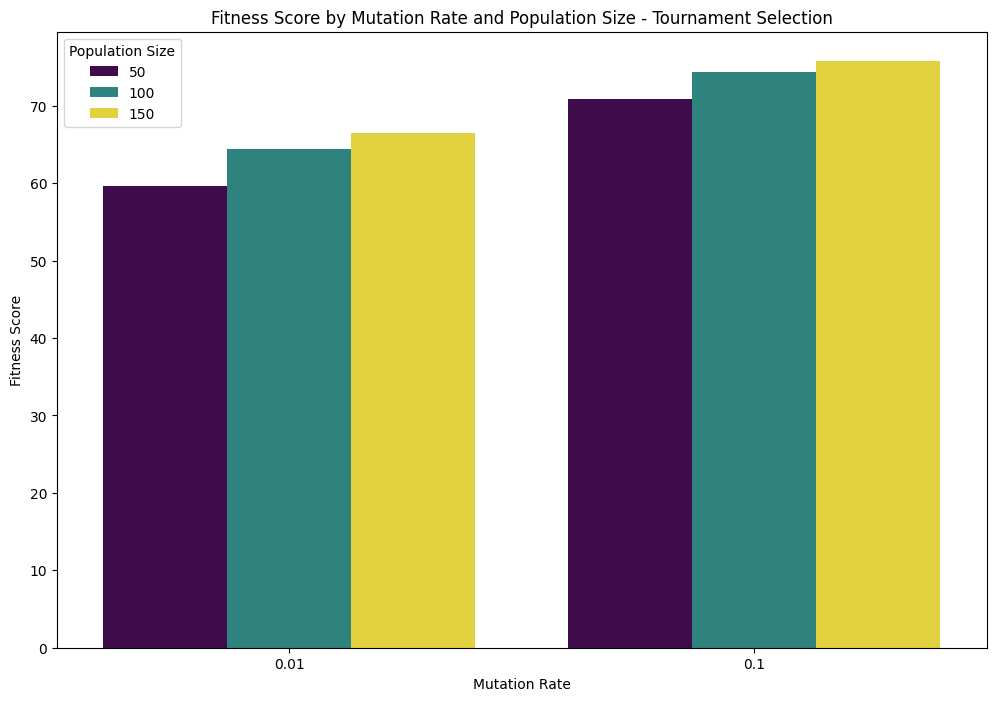

In [47]:
# Plot fitness scores for different mutation rates using bar plot
bar_plot_data_tournament = results_tournament.groupby(['mutation_rate', 'pop_size']).agg({'fitness': 'mean'}).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='mutation_rate', y='fitness', hue='pop_size', data=bar_plot_data_tournament, palette='viridis')
plt.title('Fitness Score by Mutation Rate and Population Size - Tournament Selection')
plt.xlabel('Mutation Rate')
plt.ylabel('Fitness Score')
plt.legend(title='Population Size')
plt.show()

In [48]:
# Perform grid search for roulette wheel selection
results_roulette, best_params_roulette, best_fitness_roulette, best_portfolio_roulette = perform_grid_search('roulette')

print("Best Hyperparameters (Roulette Wheel):", best_params_roulette)
print("Best Fitness Score (Roulette Wheel):", best_fitness_roulette)
print("Best Portfolio (Roulette Wheel):", best_portfolio_roulette)

Best Hyperparameters (Roulette Wheel): (150, 200, 0.1, 0.5, 1.0)
Best Fitness Score (Roulette Wheel): 80.1200062500785
Best Portfolio (Roulette Wheel): [3.36516709e-04 3.51455708e-04 2.21328586e-04 7.75507691e-05
 1.91331795e-04 1.68646187e-04 9.25225718e-05 5.93862454e-05
 1.53821916e-04 2.13374463e-04 2.11737041e-04 5.14781068e-05
 1.02590541e-04 3.10665228e-05 1.77135939e-05 1.44717550e-03
 2.19616211e-03 1.79847837e-03 1.11097289e-03 1.50416022e-03
 1.25486991e-03 2.69139577e-04 3.50516268e-04 2.03292154e-04
 3.57391430e-04 3.68427586e-04 2.83136241e-05 1.74491871e-05
 2.48399108e-05 1.15993248e-05 1.04726765e-05 3.01738756e-04
 3.19733613e-04 3.95894141e-04 3.59932362e-04 2.09405689e-04
 5.12307180e-06 1.05106480e-04 8.19817992e-06 1.99471373e-04
 1.36495646e-04 3.84946918e-05 5.07965646e-05 9.93871153e-05
 1.39955157e-04 1.13566568e-04 1.73982037e-04 1.46330936e-03
 2.55934499e-03 3.47435498e-03 9.51278260e-04 4.88168260e-03
 3.12976144e-04 3.25539443e-05 1.72629980e-04 1.1499709

In [49]:
results_roulette.head(20)

,pop_size,generations,mutation_rate,alpha,beta,selection,fitness
0,50,100,0.01,0.5,0.5,roulette,47.337516
1,50,100,0.01,0.5,1.0,roulette,50.651950
2,50,100,0.01,1.0,0.5,roulette,39.580327
3,50,100,0.01,1.0,1.0,roulette,50.644149
4,50,100,0.10,0.5,0.5,roulette,42.847493
5,50,100,0.10,0.5,1.0,roulette,60.621227
6,50,100,0.10,1.0,0.5,roulette,43.933986
7,50,100,0.10,1.0,1.0,roulette,63.111003
8,50,200,0.01,0.5,0.5,roulette,38.199514
9,50,200,0.01,0.5,1.0,roulette,59.666293


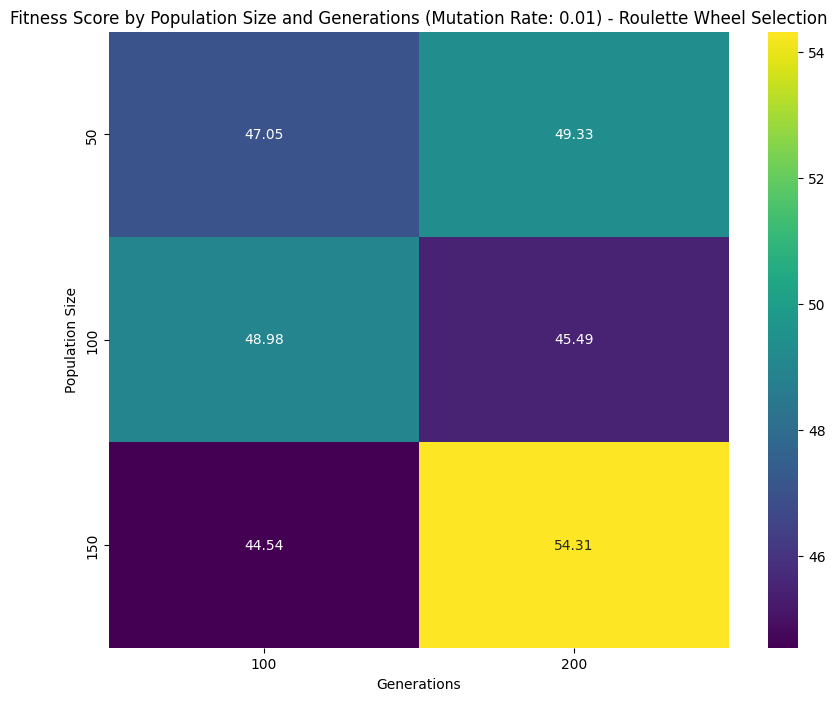

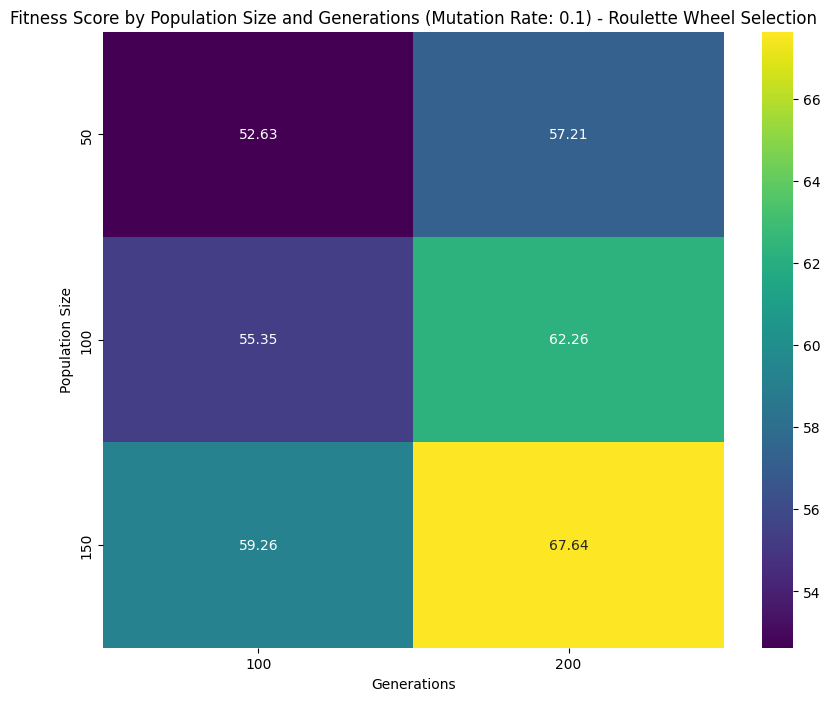

In [50]:
# Plot a heatmap of fitness scores
heatmap_data_roulette = results_roulette.groupby(['pop_size', 'generations', 'mutation_rate']).agg({'fitness': 'mean'}).reset_index()

# Get unique mutation rates
mutation_rates_roulette = heatmap_data_roulette['mutation_rate'].unique()

# Create heatmaps for each mutation rate
for mutation_rate in mutation_rates_roulette:
    subset = heatmap_data_roulette[heatmap_data_roulette['mutation_rate'] == mutation_rate]
    heatmap_data_pivot = subset.pivot(index='pop_size', columns='generations', values='fitness')

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data_pivot, annot=True, fmt=".2f", cmap='viridis')
    plt.title(f'Fitness Score by Population Size and Generations (Mutation Rate: {mutation_rate}) - Roulette Wheel Selection')
    plt.xlabel('Generations')
    plt.ylabel('Population Size')
    plt.show()

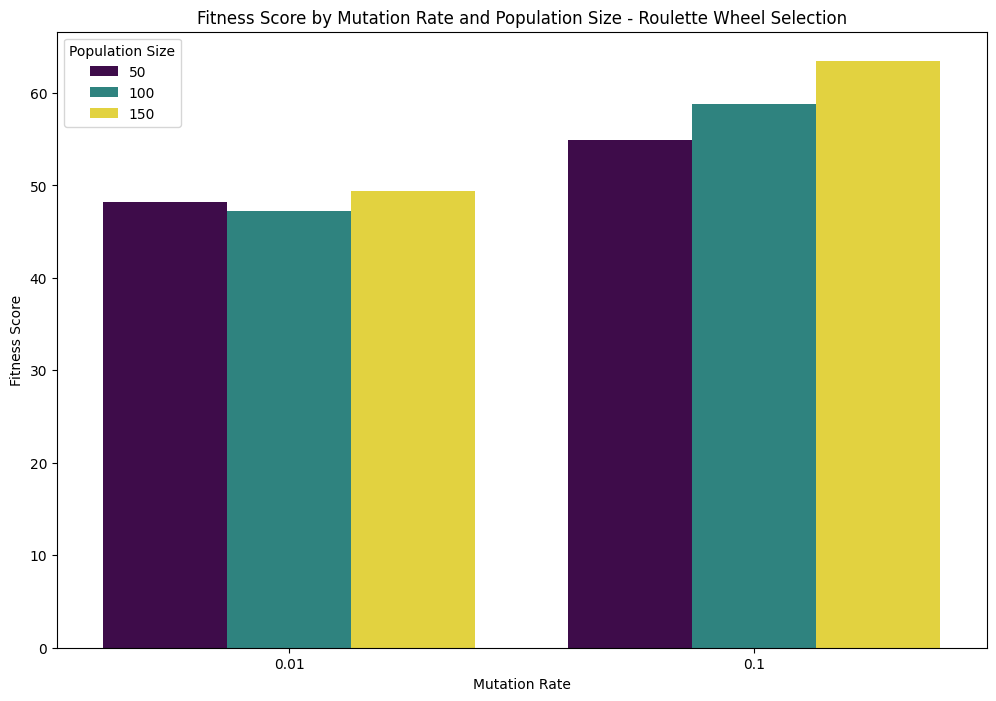

In [51]:
# Plot fitness scores for different mutation rates using bar plot
bar_plot_data_roulette = results_roulette.groupby(['mutation_rate', 'pop_size']).agg({'fitness': 'mean'}).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='mutation_rate', y='fitness', hue='pop_size', data=bar_plot_data_roulette, palette='viridis')
plt.title('Fitness Score by Mutation Rate and Population Size - Roulette Wheel Selection')
plt.xlabel('Mutation Rate')
plt.ylabel('Fitness Score')
plt.legend(title='Population Size')
plt.show()

In [52]:
# Compare the best portfolios from tournament and roulette wheel selection
portfolio_df_tournament = make_portfolio_df(best_portfolio_tournament)
print("Best Portfolio with Tournament Selection:")
print(portfolio_df_tournament.head(10))

portfolio_df_roulette = make_portfolio_df(best_portfolio_roulette)
print("\nBest Portfolio with Roulette Wheel Selection:")
print(portfolio_df_roulette.head(10))

Best Portfolio with Tournament Selection:
  Ticker    Weight
0   CTRA  0.865560
1    OXY  0.111250
2   CSCO  0.001443
3   CTSH  0.000707
4    CVX  0.000690
5    CVS  0.000662
6      D  0.000634
7   COST  0.000507
8    WFC  0.000497
9    CRM  0.000489

Best Portfolio with Roulette Wheel Selection:
  Ticker    Weight
0   CTRA  0.442596
1     GE  0.343678
2    HES  0.098679
3    TXT  0.013462
4     NI  0.005569
5    EFX  0.004946
6    BSX  0.004882
7     EW  0.004102
8     BR  0.003474
9    ROK  0.002621


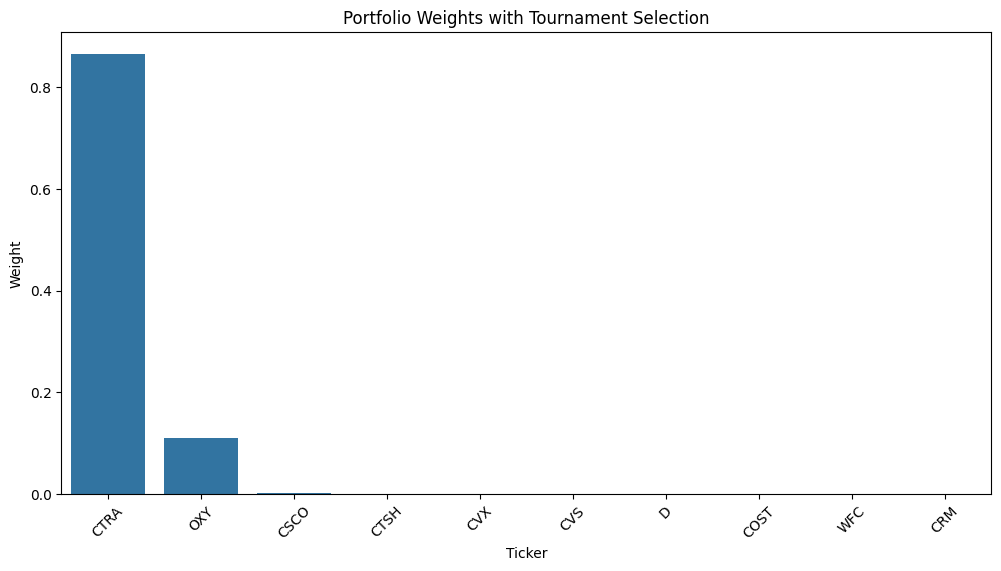

In [53]:
# Plot the portfolio weights with tournament selection
plot_portfolio_weights(portfolio_df_tournament, 'Portfolio Weights with Tournament Selection')

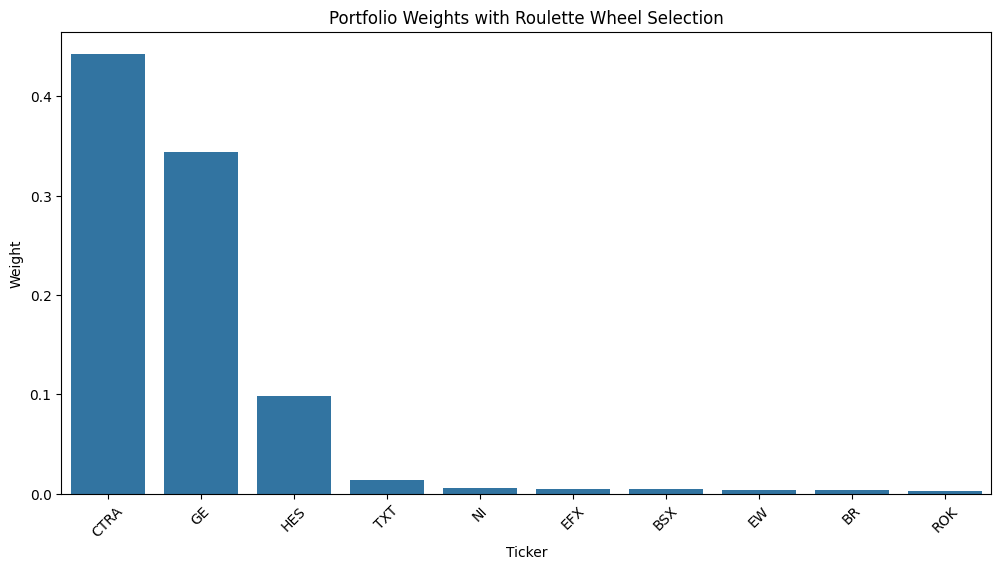

In [54]:
# Plot the portfolio weights with roulette wheel selection
plot_portfolio_weights(portfolio_df_roulette, 'Portfolio Weights with Roulette Wheel Selection')

In [55]:
# Compare the performance of the best portfolios
portfolio_return_tournament, portfolio_risk_tournament, portfolio_sharpe_tournament = calculate_portfolio_performance(best_portfolio_tournament, returns, risks, sharpe_ratios)
print("Portfolio Performance with Tournament Selection:")
print(f"Return: {portfolio_return_tournament:.4f}")
print(f"Risk: {portfolio_risk_tournament:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe_tournament:.4f}")

portfolio_return_roulette, portfolio_risk_roulette, portfolio_sharpe_roulette = calculate_portfolio_performance(best_portfolio_roulette, returns, risks, sharpe_ratios)
print("\nPortfolio Performance with Roulette Wheel Selection:")
print(f"Return: {portfolio_return_roulette:.4f}")
print(f"Risk: {portfolio_risk_roulette:.4f}")
print(f"Sharpe Ratio: {portfolio_sharpe_roulette:.4f}")

Portfolio Performance with Tournament Selection:
Return: 0.0321
Risk: 0.5407
Sharpe Ratio: -1.1807

Portfolio Performance with Roulette Wheel Selection:
Return: 0.0138
Risk: 0.4815
Sharpe Ratio: -1.4104


In [56]:
# Compare the ESG scores of the best portfolios
portfolio_esg_tournament, portfolio_env_tournament, portfolio_soc_tournament, portfolio_gov_tournament = calculate_portfolio_esg(best_portfolio_tournament, esg_scores, env_scores, soc_scores, gov_scores)
print("Portfolio ESG Score with Tournament Selection:", f"{portfolio_esg_tournament:.4f}")
print("Portfolio Environment Score with Tournament Selection:", f"{portfolio_env_tournament:.4f}")
print("Portfolio Social Score with Tournament Selection:", f"{portfolio_soc_tournament:.4f}")
print("Portfolio Governance Score with Tournament Selection:", f"{portfolio_gov_tournament:.4f}")

portfolio_esg_roulette, portfolio_env_roulette, portfolio_soc_roulette, portfolio_gov_roulette = calculate_portfolio_esg(best_portfolio_roulette, esg_scores, env_scores, soc_scores, gov_scores)
print("\nPortfolio ESG Score with Roulette Wheel Selection:", f"{portfolio_esg_roulette:.4f}")
print("Portfolio Environment Score with Roulette Wheel Selection:", f"{portfolio_env_roulette:.4f}")
print("Portfolio Social Score with Roulette Wheel Selection:", f"{portfolio_soc_roulette:.4f}")
print("Portfolio Governance Score with Roulette Wheel Selection:", f"{portfolio_gov_roulette:.4f}")

Portfolio ESG Score with Tournament Selection: 45.1519
Portfolio Environment Score with Tournament Selection: 23.7450
Portfolio Social Score with Tournament Selection: 12.9133
Portfolio Governance Score with Tournament Selection: 8.4947

Portfolio ESG Score with Roulette Wheel Selection: 40.6459
Portfolio Environment Score with Roulette Wheel Selection: 18.4016
Portfolio Social Score with Roulette Wheel Selection: 12.9109
Portfolio Governance Score with Roulette Wheel Selection: 9.3345


In [57]:
# Compare the fitness scores of the best portfolios
fitness_tournament = calculate_fitness(best_portfolio_tournament, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores)
fitness_roulette = calculate_fitness(best_portfolio_roulette, returns, risks, sharpe_ratios, esg_scores, env_scores, soc_scores, gov_scores)

print("Fitness Score with Tournament Selection:", fitness_tournament)
print("Fitness Score with Roulette Wheel Selection:", fitness_roulette)

Fitness Score with Tournament Selection: 88.61566881698518
Fitness Score with Roulette Wheel Selection: 79.4148164207087


In [58]:
# Compare the hyperparameters of the best portfolios
print("Best Hyperparameters (Tournament):", best_params_tournament)
print("Best Hyperparameters (Roulette Wheel):", best_params_roulette)

Best Hyperparameters (Tournament): (150, 200, 0.1, 0.5, 1.0)
Best Hyperparameters (Roulette Wheel): (150, 200, 0.1, 0.5, 1.0)


### Analysis of Results with Hyperparameter Tuning

- Diversity in Hyperparameters: For both selection methods, the best hyperparameters were identical, indicating a preference for a larger population size and more generations. This suggests that a more extensive and prolonged search allows the genetic algorithm to explore a broader range of potential solutions, thereby improving fitness. Moreover, an optimal mutation rate of 0.1 indicates that increasing the mutation rate might help maintaining diversity within the population and preventing premature convergence.

- Population Size and Generations: From the heatmaps, we can observe that the fitness score generally increases with larger population sizes and more generations, as previously noted. This pattern holds true for both selection methods, reinforcing the importance of allowing the algorithm enough time and resources to optimize the portfolios effectively.
  
- Differences in Portfolio Composition: In contrast to previous results, the tournament selection method resulted in a more concentrated portfolio, with almost all the weight in just two stocks, indicating a focus on optimizing the performance of a few high-performing stocks. Conversely, the roulette wheel selection method produced a more diversified portfolio, spreading the investment across a broader range of stocks, potentially reducing risk by avoiding over-concentration.

- Financial Performance: Both methods produced portfolios with negative Sharpe ratios, reflecting the challenging market conditions of the chosen period (2022). Indeed, as seen during EDA, more than half of the stocks had negative annual returns during this year. Despite this, the tournament selection method achieved a higher return and a slightly better risk-adjusted performance compared to the roulette wheel selection method.

- ESG Considerations: The tournament selection method resulted once again in a portfolio with higher overall ESG scores, especially in the environmental aspect. This suggests that the tournament selection method can better balance financial performance and ESG considerations. The roulette wheel selection method, while more diversified, had lower ESG scores overall.

- Fitness Scores: The fitness scores were higher for the tournament selection method, indicating that it generally produced better-balanced portfolios considering both financial and ESG criteria. This proves the effectiveness of the tournament selection method in this specific application.

## Conclusion

This project explored the optimization of green investment portfolios using genetic algorithms, integrating ESG (Environmental, Social and Governance) scores with traditional financial metrics like returns, risks and Sharpe ratios. We applied genetic algorithms with tournament and roulette wheel selection methods to find the best portfolios balancing financial performance and sustainability.

The hyperparameter tuning revealed that larger population sizes and more generations generally improve the algorithm's performance. Both methods preferred a higher mutation rate of 0.1 to maintain diversity and prevent premature convergence. Tournament selection produced higher fitness scores and better ESG ratings, though it resulted in more concentrated portfolios. In contrast, roulette wheel selection led to more diversified portfolios but with lower overall fitness and ESG scores.

We observed that fitness scores increase with population size and the number of generations, showing the need for extensive optimization processes. The tournament selection method achieved higher returns and better risk-adjusted performance, despite the challenging market conditions of 2022.

Genetic algorithms show great potential in sustainable finance, providing a method for investors to consider both financial returns and ESG criteria in portfolio optimization. Future work could improve this approach by refining fitness functions to better capture the complexities of financial and ESG performance, exploring additional selection mechanisms like elitism or rank-based selection, and incorporating more extensive ESG datasets to improve the robustness of the model. Additionally, extending the analysis to include multiple years of data could provide a more comprehensive view of portfolio performance over time. This project demonstrates the importance of integrating ESG considerations into portfolio optimization, supporting the transition towards more sustainable and responsible investment practices.